<a href="https://colab.research.google.com/github/RH00000/Rice_LLM_Replicability_Project/blob/main/prompt_5_ensembling_with_comparative_prompt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install -q google-generativeai pandas openpyxl

In [ ]:
#import
from google import genai
import os
import requests
import pandas as pd
import re
import time
from google.colab import files, userdata
userdata.get('GEMINI_API_KEY')

In [21]:
#Initialize Gemini Client
client = genai.Client(api_key=userdata.get('GEMINI_API_KEY'))

In [22]:
#Upload and Load Excel File
uploaded = files.upload()
excel_file = list(uploaded.keys())[0]
df = pd.read_excel(excel_file, sheet_name=0).dropna(how="all")

Saving data_for_prompt_5_ensembling_with_comparative_prompt.xlsx to data_for_prompt_5_ensembling_with_comparative_prompt.xlsx


In [24]:
# List of required ensemble‑prompt columns
prompt_cols = [
    "sample_size_prompt",
    "p_value_prompt",
    "method_complexity_prompt",
    "author_citation_prompt",
    "subfield_prompt",
    "baseline_prompt"
]

# Ensure they all exist
missing = [col for col in prompt_cols if col not in df.columns]
if missing:
    raise KeyError(f"Excel is missing the following prompt columns: {', '.join(missing)}")
else:
    print("All ensemble prompt columns exist:", ", ".join(prompt_cols))


All ensemble prompt columns exist: sample_size_prompt, p_value_prompt, method_complexity_prompt, author_citation_prompt, subfield_prompt, baseline_prompt


In [25]:
#Helper to extract probability from first line
def extract_prob(text):
    first_line = text.strip().splitlines()[0]
    m = re.search(r"\b(0(?:\.\d+)?|1(?:\.0+)?)\b", first_line)
    return float(m.group(0)) if m else None

In [26]:
# Prepare storage for each prompt's probs + avg + outputs
per_prompt_probs = {col.replace("_prompt", "_prob"): [] for col in prompt_cols}
avg_probs = []
outputs = []

# Resume support (unchanged)
autosave_file = 'autosave_file'
start_idx = 0
if os.path.exists(autosave_file):
    try:
        saved = pd.read_csv(autosave_file)
        start_idx = len(saved)
        if start_idx > 0:
            avg_probs = saved["replication_probability"].tolist()
            outputs   = saved["model_output"].tolist()
            for prob_col in per_prompt_probs:
                per_prompt_probs[prob_col] = saved[prob_col].tolist()
    except Exception as e:
        print(f"Error loading autosave file: {e}. Starting fresh.")
        start_idx = 0
        avg_probs, outputs = [], []
        for prob_col in per_prompt_probs:
            per_prompt_probs[prob_col] = []

if start_idx > 0:
    print(f"Resuming from row {start_idx}")

# Main loop
for idx in df.index[start_idx:]:
    this_probs   = []
    this_outputs = []

    # for each of the 5 prompts
    for col in prompt_cols:
        prompt = df.at[idx, col]

        max_retries = 10
        wait_time = 7  # seconds

        for attempt in range(max_retries):
            try:
                response = client.models.generate_content(
                    model="gemini-2.5-pro",
                    contents=[prompt]
                )
                text = response.candidates[0].content.parts[0].text.strip()
                prob = extract_prob(text) or 0.0
                break  # success, exit retry loop
            except Exception as e:
                error_message = str(e)
                if "UNAVAILABLE" in error_message or "error" in error_message or "Error" in error_message or "ERROR" in error_message:
                    print(f"[Retry {attempt + 1}/{max_retries}] Gemini overloaded. Waiting {wait_time} seconds...")
                    time.sleep(wait_time)
                    wait_time = min(wait_time * 1.5, 60)  # exponential backoff up to 1 min
                else:
                    print(f"Non-retryable error on row {idx}: {e}")
                    text = f"Error: {e}"
                    prob = 0.0
                    break
        else:
            print(f"Max retries reached for row {idx}.")
            text = f"Error: Max retries for UNAVAILABLE"
            prob = 0.0

        this_probs.append(prob) # Append the probability to the list
        this_outputs.append(text)

        # append to the per‑prompt list
        key = col.replace("_prompt", "_prob")
        per_prompt_probs[key].append(prob)
        time.sleep(2.0)

    # average and append
    avg = sum(this_probs) / len(this_probs)
    avg_probs.append(avg)
    outputs.append("\n---\n".join(this_outputs))

    # autosave every 10
    if len(avg_probs) % 10 == 0:
        df_partial = df.iloc[:len(avg_probs)].copy()
        # assign all prob columns
        for key, lst in per_prompt_probs.items():
            df_partial[key] = lst
        df_partial["replication_probability"] = avg_probs
        df_partial["model_output"]            = outputs
        df_partial.to_csv(autosave_file, index=False)
        print(f"Autosaved through row {len(avg_probs)-1}")

# Write back to df
for key, lst in per_prompt_probs.items():
    df[key] = lst
df["replication_probability"] = avg_probs
df["model_output"]            = outputs

# Final save
df.to_csv("predictions_output_final.csv", index=False)
files.download("predictions_output_final.csv")

Autosaved through row 9
[Retry 1/10] Gemini overloaded. Waiting 7 seconds...
[Retry 2/10] Gemini overloaded. Waiting 10.5 seconds...
[Retry 1/10] Gemini overloaded. Waiting 7 seconds...
Autosaved through row 19
[Retry 1/10] Gemini overloaded. Waiting 7 seconds...
Autosaved through row 29
[Retry 1/10] Gemini overloaded. Waiting 7 seconds...
Autosaved through row 39
Autosaved through row 49
Autosaved through row 59
Autosaved through row 69
[Retry 1/10] Gemini overloaded. Waiting 7 seconds...
Autosaved through row 79
[Retry 1/10] Gemini overloaded. Waiting 7 seconds...
[Retry 1/10] Gemini overloaded. Waiting 7 seconds...
[Retry 2/10] Gemini overloaded. Waiting 10.5 seconds...
[Retry 1/10] Gemini overloaded. Waiting 7 seconds...
[Retry 1/10] Gemini overloaded. Waiting 7 seconds...
[Retry 1/10] Gemini overloaded. Waiting 7 seconds...
[Retry 1/10] Gemini overloaded. Waiting 7 seconds...
Autosaved through row 89
[Retry 1/10] Gemini overloaded. Waiting 7 seconds...
[Retry 2/10] Gemini overload

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# another 4 hours

In [28]:
!pip install -q scikit-learn

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve

In [30]:
df_result = pd.read_csv("predictions_output_final.csv")

In [31]:
# Drop rows with any zero in the individual prompt probabilities
prob_cols = [
    "sample_size_prob",
    "p_value_prob",
    "method_complexity_prob",
    "author_citation_prob",
    "subfield_prob"
]

# Remove rows with 0 in any of the five prompt probabilities
df_filtered = df_result.copy()
for col in prob_cols:
    df_filtered = df_filtered[df_filtered[col] != 0]

# Drop rows where "replication_probability" is blank
df_filtered = df_filtered.dropna(subset=["replication_probability"]).copy()

# Convert replication_probability to float
df_filtered["replication_probability"] = df_filtered["replication_probability"].astype(float)

# Convert ground truth to binary labels
df_filtered["replicated"] = df_filtered["Result (replicated?)"].str.strip().str.lower().map({"yes": 1, "no": 0})


In [37]:
# Compute AUC
auc = roc_auc_score(df_filtered["replicated"], df_filtered["replication_probability"])
print(f"AUC: {auc:.4f}")

AUC: 0.7047


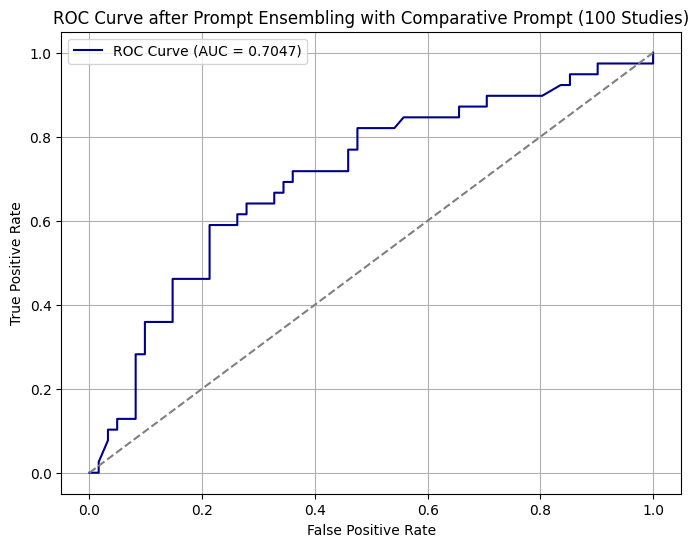

In [39]:
from matplotlib import pyplot as plt

# ROC curve
fpr, tpr, _ = roc_curve(df_filtered["replicated"], df_filtered["replication_probability"])

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})", color="darkblue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve after Prompt Ensembling with Comparative Prompt (100 Studies)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("Number of studies used:", len(df_filtered))

Number of studies used: 100
